# Imports

2025-02-24 10:00:43.963251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 10:00:43.963298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 10:00:43.977045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
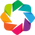

In [1]:
from utils.peak_extraction import *


# Run full pipeline

In [ ]:
input_dir = 'i:\Live Imaging\Test ASAP5'
output_dir = 'i:\Live Imaging\ASAP5_Silvia_Final_Data_Output'

process_dataset(input_dir, output_dir)


In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Retained 3 components


c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\peak_extraction.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_df = pd.concat([experiment_df, roi_df], ignore_index=True)
c:\Users\Sudhof Lab\Desktop\fluorescent_peak_analysis\utils\peak_extraction.py:201: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be r

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

def plot_calcium_traces(data, sampling_rate, traces_to_plot=None, zoom_trace_index=None, zoom_window=None, time_scale_bar=5, delta_f_scale=0.1):
    """
    Plot calcium imaging traces with raw ΔF/F₀ values.
    
    Parameters:
    -----------
    data : numpy.ndarray
        2D array where each column is an ROI and each row is a time sample (ΔF/F₀ values)
    sampling_rate : float
        Sampling rate in Hz
    traces_to_plot : list of int
        List of indices of traces to plot (default=None, plot all traces)
    zoom_trace_index : int
        Index of trace to zoom in on (default=None, use middle trace)
    zoom_window : tuple
        Tuple of (start, end) times for zoomed in window (default=None, use 1/3 of trace duration)
    time_scale_bar : float
        Length of time scale bar in seconds (default=5)
    delta_f_scale : float
        Scale for ΔF/F₀ bar (default=0.1, representing 10%)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The resulting figure
    """
    # Create figure with custom layout
    fig = plt.figure(figsize=(10, 15))
    gs = GridSpec(2, 1, height_ratios=[4, 1], hspace=0.3)
    
    # Main plot for all traces
    ax_main = fig.add_subplot(gs[0])
    
    # Process trace selection
    if traces_to_plot is not None:
        filtered_data = data[:, traces_to_plot]
    else:
        filtered_data = data
    
    num_traces = filtered_data.shape[1]
    
    # Default to middle trace if not specified
    if zoom_trace_index is None:
        zoom_trace_index = num_traces // 2
    elif traces_to_plot is not None:
        # Make sure zoom_trace_index refers to the index in the filtered data
        if zoom_trace_index not in traces_to_plot:
            # If the requested zoom trace isn't in traces_to_plot, use the first one
            zoom_trace_index = 0
        else:
            # Convert from original index to filtered index
            zoom_trace_index = traces_to_plot.index(zoom_trace_index)
    
    spacing = delta_f_scale * 5  # Use ΔF/F₀ scale for spacing
    
    zoom_start_idx = None
    zoom_end_idx = None
    zoom_start = None
    zoom_duration = None
    
    for i in range(num_traces):
        # Get trace and add offset
        trace = filtered_data[:, i]
        offset = (num_traces - i - 1) * spacing
        
        # Plot in black or gray alternating
        color = 'black' if i % 2 == 0 else 'gray'
        time = np.arange(len(trace)) / sampling_rate
        ax_main.plot(time, trace + offset, color=color, linewidth=0.5)
        
        # Highlight zoomed section if this is the selected trace
        if i == zoom_trace_index:
            # Determine zoom window
            if zoom_window is not None:
                zoom_start, zoom_end = zoom_window
                zoom_duration = zoom_end - zoom_start
            else:
                zoom_start = len(trace) / (4 * sampling_rate)
                zoom_duration = len(trace) / (3 * sampling_rate)
                zoom_end = zoom_start + zoom_duration
            zoom_start_idx = int(zoom_start * sampling_rate)
            zoom_end_idx = int(zoom_end * sampling_rate)
            
            zoom_y_min = min(trace[zoom_start_idx:zoom_end_idx]) + offset - delta_f_scale/4
            zoom_y_max = max(trace[zoom_start_idx:zoom_end_idx]) + offset + delta_f_scale/4
            rect = patches.Rectangle((zoom_start, zoom_y_min),
                                  zoom_duration,
                                  zoom_y_max - zoom_y_min,
                                  linewidth=2,
                                  edgecolor='#006400',
                                  facecolor='none')
            ax_main.add_patch(rect)
    
    # Add scale bars that touch each other (L-shaped)
    x_max = len(filtered_data) / sampling_rate
    y_max = num_traces * spacing
    
    # Scale bar origin point for main plot
    scale_origin_x = x_max - time_scale_bar
    scale_origin_y = y_max + spacing/2
    
    # Time scale bar (horizontal)
    ax_main.plot([scale_origin_x, x_max], 
                 [scale_origin_y, scale_origin_y], 
                 'k-', linewidth=2)
    ax_main.text(scale_origin_x + time_scale_bar/2, scale_origin_y + spacing/4, 
                f'{time_scale_bar} s', ha='center')
    
    # ΔF/F₀ scale bar (vertical)
    ax_main.plot([x_max, x_max], 
                 [scale_origin_y, scale_origin_y + delta_f_scale], 
                 'k-', linewidth=2)
    ax_main.text(x_max + 0.5, scale_origin_y + delta_f_scale/2, 
                f'{int(delta_f_scale*100)}% ΔF/F₀', va='center', ha='left')
    
    # Customize main plot appearance
    ax_main.set_ylim(-spacing/2, scale_origin_y + delta_f_scale + spacing/2)  # Make room for scale bars
    ax_main.set_xlim(-1, x_max + 1.5)  # Make room for scale bar text
    ax_main.set_ylabel('ROI #')
    ax_main.set_yticks([i * spacing for i in range(num_traces)])
    
    # Fix y-axis labels to show actual ROI indices
    if traces_to_plot is not None:
        ax_main.set_yticklabels([str(traces_to_plot[num_traces - i - 1]) for i in range(num_traces)])
    else:
        ax_main.set_yticklabels([str(num_traces - i - 1) for i in range(num_traces)])
    
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.spines['bottom'].set_visible(False)
    ax_main.set_xticks([])
    
    # Add zoom-in panel with actual zoomed data
    ax_zoom = fig.add_subplot(gs[1])
    zoomed_trace = filtered_data[:, zoom_trace_index]
    
    # Extract just the zoomed portion
    zoomed_segment = zoomed_trace[zoom_start_idx:zoom_end_idx]
    zoomed_time = np.arange(len(zoomed_segment)) / sampling_rate
    
    # Draw blue border around the subplot
    y_min = min(zoomed_segment) - delta_f_scale/4
    y_max = max(zoomed_segment) + delta_f_scale/4
    
    # Plot the zoomed trace
    ax_zoom.plot(zoomed_time, zoomed_segment, 'k-', linewidth=1)
    
    # Add blue border around the entire zoomed plot area
    border_rect = patches.Rectangle(
        (0, y_min),
        zoom_duration,
        y_max - y_min,
        linewidth=2,
        edgecolor='#006400',
        facecolor='none'
    )
    ax_zoom.add_patch(border_rect)
    
    # Calculate better placement for scale bars (above the trace)
    delta_y = y_max - y_min
    
    # Place scale bars above the trace
    scale_bar_y = y_max + delta_y * 0.1
    
    
    # Origin point for zoom scale bars (L-shaped, touching)
    zoom_scale_origin_x = zoom_duration - time_scale_bar
    
    # Time scale bar (horizontal)
    ax_zoom.plot([zoom_scale_origin_x, zoom_duration], 
                 [scale_bar_y, scale_bar_y], 
                 'k-', linewidth=2)
    ax_zoom.text(zoom_scale_origin_x + time_scale_bar/2, scale_bar_y + delta_y * 0.05, 
                f'{time_scale_bar} s', ha='center')
    
    # ΔF/F₀ scale bar (vertical)
    ax_zoom.plot([zoom_duration, zoom_duration], 
                 [scale_bar_y, scale_bar_y + delta_f_scale], 
                 'k-', linewidth=2)
    ax_zoom.text(zoom_duration + zoom_duration * 0.05, scale_bar_y + delta_f_scale/2, 
                f'{int(delta_f_scale*100)}% ΔF/F₀', va='center', ha='left')
    
    # Expand ylim to include the scale bars
    ax_zoom.set_ylim(y_min - delta_y * 0.1, scale_bar_y + delta_f_scale + delta_y * 0.1)
    ax_zoom.set_xlim(0, zoom_duration * 1.1)  # Add some padding for scale bar text
    
    # Customize zoom panel appearance
    ax_zoom.spines['top'].set_visible(False)
    ax_zoom.spines['right'].set_visible(False)
    ax_zoom.spines['bottom'].set_visible(False)
    ax_zoom.spines['left'].set_visible(False)
    ax_zoom.set_xticks([])
    ax_zoom.set_yticks([])
    
    # Add subtitle to zoom panel to indicate which ROI is being shown
    if traces_to_plot is not None:
        original_roi_index = traces_to_plot[zoom_trace_index]
    else:
        original_roi_index = zoom_trace_index
    ax_zoom.set_title(f'ROI #{original_roi_index} (zoomed)', fontsize=10)
    
    plt.tight_layout()
    return fig

# Older functions for tests and debugging

/tmp/ipykernel_403642/3512768936.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


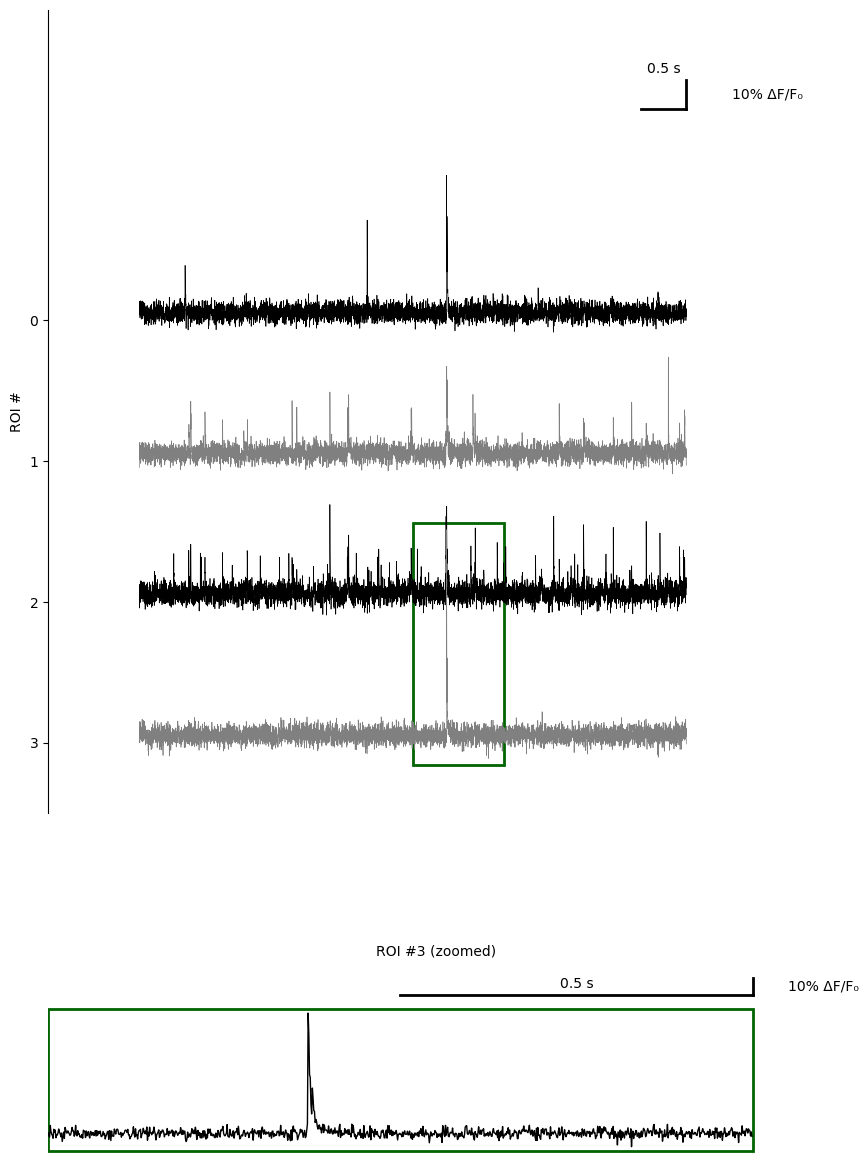

In [41]:
csv_file =  '/home/kirill/Desktop/ApoE_iGluSnFr3_Batch1_Group3_FOV10_1_MMStack_Default.ome_DFF_traces.csv'
yaml_file = '/home/kirill/Desktop/glutamate_config.yaml'
config = load_yaml_config(yaml_file)
array, df = load_data(csv_file, config)
figure = plot_calcium_traces(array, 
                             sampling_rate=config['motion_corr']['fr'], 
                             traces_to_plot=[0, 1, 2, 3], 
                             zoom_trace_index=3, 
                             zoom_window=(3, 4),
                             time_scale_bar=0.5, 
                             delta_f_scale=0.1)

#Save figure as pdf
figure.savefig('/home/kirill/Desktop/figure.pdf', format='pdf')

In [144]:
#get the experiment ids that are present in experiment_avg_firing_frequency, but not in experiment_avg_peak_amplitudes
missing_combinations = experiment_avg_firing_frequency[~experiment_avg_firing_frequency.set_index(['experiment_id']).index.isin(experiment_avg_peak_amplitudes.set_index(['experiment_id']).index)]
print(f"Missing combinations: {missing_combinations}")

#Check how many rows in experiment_avg_firing_frequency have NaN values
nan_rows_amplitude = experiment_avg_peak_amplitudes[experiment_avg_peak_amplitudes.isnull().any(axis=1)]
nan_rows_frequency = experiment_avg_firing_frequency[experiment_avg_firing_frequency.isnull().any(axis=1)]
nan_rows_synchrony = mean_synchrony_df[mean_synchrony_df.isnull().any(axis=1)]
print(f"Rows with NaN values: {nan_rows_amplitude.shape[0]}") 
print(f"Rows with NaN values: {nan_rows_frequency.shape[0]}")
print(f"Rows with NaN values: {nan_rows_synchrony.shape[0]}")

print(experiment_avg_peak_amplitudes.shape[0])
print(experiment_avg_firing_frequency.shape[0])
print(mean_synchrony_df.shape[0])


Missing combinations: Empty DataFrame
Columns: [experiment_id, mean_firing_frequency[Hz], mean_peak_to_peak_distance[ms], group]
Index: []
Rows with NaN values: 4
Rows with NaN values: 8
Rows with NaN values: 0
136
136
136


# Check if metrics are related

In [113]:
experiment_avg_peak_amplitudes.head()

,experiment_id,peak_absolute_amplitude,peak_relative_amplitude,group
117,Batch127_ApoE4_FOV9.DFF,1.701753,0.696373,ApoE4
116,Batch127_ApoE4_FOV6.DFF,1.860093,0.854574,ApoE4
115,Batch127_ApoE4_FOV5.DFF,1.439130,0.433140,ApoE4
114,Batch127_ApoE4_FOV4.DFF,1.398785,0.390678,ApoE4
113,Batch127_ApoE4_FOV3.DFF,1.436458,0.402062,ApoE4


In [114]:
experiment_avg_firing_frequency.head()

,experiment_id,mean_firing_frequency[Hz],mean_peak_to_peak_distance[ms],group
117,Batch127_ApoE4_FOV9.DFF,0.781421,1102.532475,ApoE4
116,Batch127_ApoE4_FOV6.DFF,1.034884,1107.395755,ApoE4
115,Batch127_ApoE4_FOV5.DFF,1.480480,665.288860,ApoE4
114,Batch127_ApoE4_FOV4.DFF,1.191176,863.987953,ApoE4
113,Batch127_ApoE4_FOV3.DFF,1.333333,805.976190,ApoE4


In [115]:
mean_synchrony_df.head()

,experiment_id,group,synchrony
117,Batch127_ApoE4_FOV9.DFF,ApoE4,0.895900
116,Batch127_ApoE4_FOV6.DFF,ApoE4,0.951364
115,Batch127_ApoE4_FOV5.DFF,ApoE4,0.804944
114,Batch127_ApoE4_FOV4.DFF,ApoE4,0.751276
113,Batch127_ApoE4_FOV3.DFF,ApoE4,1.000000


<Axes: xlabel='peak_absolute_amplitude', ylabel='mean_firing_frequency[Hz]'>

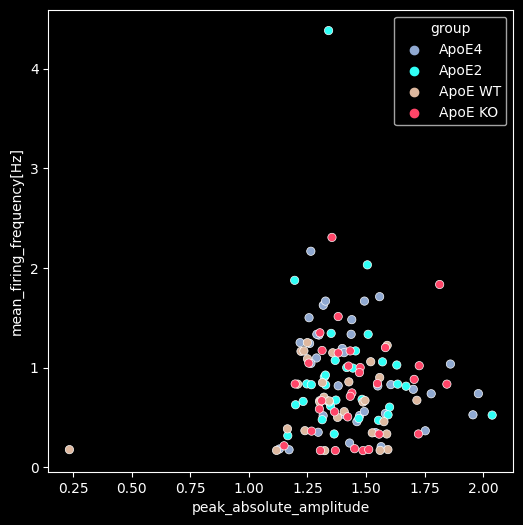

In [116]:
# Merge experiment_avg_peak_amplitudes, experiment_avg_firing_frequency, and mean_synchrony_df on experiment_id
per_experiment_metrics = experiment_avg_peak_amplitudes.merge(experiment_avg_firing_frequency, on='experiment_id').merge(mean_synchrony_df, on='experiment_id')
# Plot a scatter plot of peak amplitudes vs firing frequency
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='peak_absolute_amplitude', y='mean_firing_frequency[Hz]', hue='group', palette=group_palette)

<Axes: xlabel='peak_absolute_amplitude', ylabel='synchrony'>

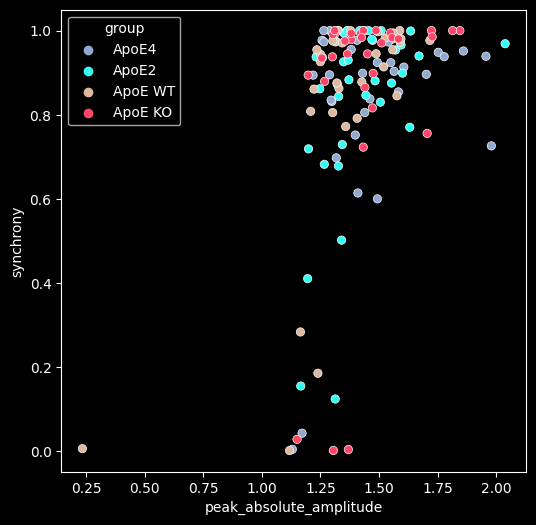

In [117]:
#Plot a scatter plot of peak amplitudes vs synchrony
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='peak_absolute_amplitude', y='synchrony', hue='group', palette=group_palette)


<Axes: xlabel='mean_firing_frequency[Hz]', ylabel='synchrony'>

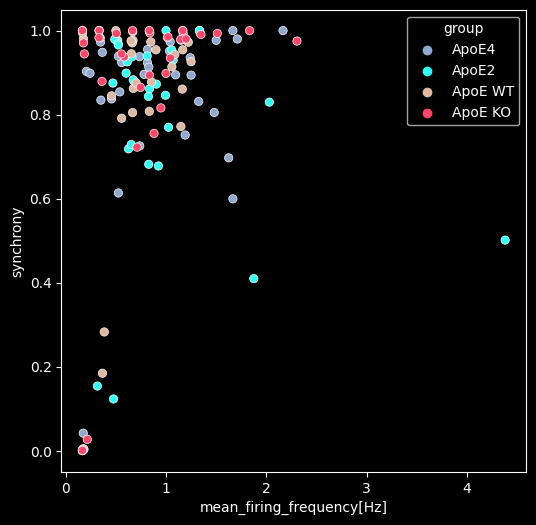

In [118]:
#Plot a scatter plot of firing frequency vs synchrony
plt.figure(figsize=(6, 6))
sns.scatterplot(data=per_experiment_metrics, x='mean_firing_frequency[Hz]', y='synchrony', hue='group', palette=group_palette)

# Look at peak height distribution

In [ ]:
experiment_id = 'Batch124_ApoE2_FOV1.DFF'
data_path = 'data'
experiment_path = join(data_path, experiment_id)

array, df = load_data(join(data_path, experiment_id + '.txt'))
experiment_df = pd.read_csv(join(experiment_path, experiment_id + '_experiment_df.csv'))
experiment_df.head()

experiment_df['noise_level'] = experiment_df['roi_id'].apply(lambda x: calc_noise_levels(array, int(x.rsplit('ROI')[1]) - 1))
    

experiment_df.head()

,roi_id,peak_time,peak_absolute_amplitude,peak_relative_amplitude,noise_level
0,ROI1,428,1.545500,0.523404,0.010076
1,ROI1,827,1.350890,0.328794,0.010076
2,ROI1,2369,1.677700,0.655604,0.010076
3,ROI1,2598,1.086602,0.064506,0.010076
4,ROI1,2959,1.145090,0.122994,0.010076


In [63]:
#For all individual experiments, plot the noise level histogram in different colors
fig = go.Figure()
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(go.Histogram(x=experiment_df_subset['noise_level'], nbinsx=50, name=experiment_id))

fig.update_layout(title='Noise Level Distribution by Experiment', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
#Use experiment_palette to color the histogram bars
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]
#Add vertical lines at noise cutoffs
fig.add_vline(x=mean_noise - 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='-1 STD')
fig.add_vline(x=mean_noise + 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='+1 STD')
fig.add_vline(x=mean_noise - 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='-2 STD')
fig.add_vline(x=mean_noise + 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='+2 STD')

fig.show()
#Save as html
fig.write_html('noise_level_histogram_by_experiment.html')


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Loop through each experiment and add a normalized histogram trace
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(
        go.Histogram(
            x=experiment_df_subset['noise_level'],
            nbinsx=50,
            name=experiment_id,
            histnorm='percent'  # Normalize to percentage
        )
    )

# Update layout for a dark theme and axis labels
fig.update_layout(
    title='Noise Level Distribution by Experiment',
    xaxis_title='Noise Level [dF/F]',
    yaxis_title='Percentage of ROIs',
    template='plotly_dark'
)
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]

#Add vertical lines at noise cutoffs
fig.add_vline(x=mean_noise - 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='-1 STD')
fig.add_vline(x=mean_noise + 1 * std_noise, line_dash='dash', line_color='gray', annotation_text='+1 STD')
fig.add_vline(x=mean_noise - 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='-2 STD')
fig.add_vline(x=mean_noise + 2 * std_noise, line_dash='dash', line_color='gray', annotation_text='+2 STD')

fig.show()
#Save as html
fig.write_html('noise_level_histogram_by_experiment_normalized.html')


In [ ]:
#Plot a histogram of the noise levels using plotly
fig = go.Figure()
fig.add_trace(go.Histogram(x=experiment_df['noise_level'], nbinsx=50))
fig.update_layout(title='Noise Level Distribution', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
fig.show()

In [48]:
mean_noise_level = experiment_df['noise_level'].mean()

below_mean_subset = experiment_df[experiment_df['noise_level'] < mean_noise_level]
above_mean_subset = experiment_df[experiment_df['noise_level'] >= mean_noise_level]

In [49]:
#Plot a histogram of the peak heights
fig = go.Figure()
# fig.add_trace(go.Histogram(x=experiment_df['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=below_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=above_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Higher noise ROIs'))
# fig.update_layout(title='Peak Heights Histogram', xaxis_title='Peak Height [dF/F]', yaxis_title='Count')
#Make the plot dark
fig.update_layout(template='plotly_dark')
# fig.write_html(os.path.join(data_output_dir, 'peak_heights_histogram.html'))
fig.write_image(os.path.join('peak_heights_histogram.pdf'), format='pdf')
fig.show()

## Highlight increase in noise with ROI id increase

In [111]:
#Plot traces 0 and 78
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 78], name='ROI 78'))
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 0], name='ROI 0'))
# fig.update_layout(title='Raw Signal Traces', xaxis_title='Time', yaxis_title='Intensity')
# fig.show()

#Now plot the same thing but so that it can be pasted onto black background
fig = go.Figure()
#Create an array for the x axis corresponding to np.arange(array.shape[0]), but in units of seconds rather than ms
x_arr = np.arange(array.shape[0]) / 100
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 78], name='ROI 79'))
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 0], name='ROI 1'))
fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()
#Also export as html, pdf, and png
output_file_root = os.path.join(data_output_dir, 'sample_trace_plot')
fig.write_html(output_file_root + '.html')
fig.write_image(output_file_root + '.pdf', format='pdf')
fig.write_image(output_file_root + '.png', format='png')

In [46]:
plot_noise_level(array)

# Visualize matlab-based ROIs

In [ ]:
from scipy.io import loadmat
import numpy as np
import napari
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params

# dataset dependent parameters
fr = 1000                             # imaging rate in frames per second
decay_time = 0.002                    # Length of a typical transient in seconds (see source/Getting_Started.rst)

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between patches (size of patch strides+overlaps)
max_shifts = (6, 6)         # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 0                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.5            # merging threshold, max correlation allowed
rf =  12                  # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = None          # amount of overlap between the patches in pixels
K = 90                      # number of components per patch
method_init = 'graph_nmf'   # initialization method (you could also use 'sparse_nmf' for dendritic data)
alpha = 0.5                 # sparsity regularizer term (default is 0.5): used only for sparse_nmf
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during initialization

opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'p': p,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'alpha_snmf': alpha,  # used only for sparse_nmf
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr}

opts = params.CNMFParams(params_dict=opts_dict)

In [ ]:
from skimage import measure, io
import seaborn as sns

#Load matlab file with ROIs (128x128xNc)

mat = loadmat('/home/kirill/Downloads/Batch126_ApoE4_FOV5_masks.mat')
ROIs = np.array(mat['spatial'])

fnames = ['/mnt/a5e90321-8b33-423f-ad87-3e20a7c42f90/glutamate_data/ApoE iGluSnFr3/ApoE4/Batch126_ApoE4_FOV5_1/Batch126_ApoE4_FOV5_1_MMStack_Default.ome.tif']
if 'dview' in locals():  # locals contains list of current local variables
    print('Closing previous cluster')
    cm.stop_server(dview=dview)
print("Setting up new cluster")
c, dview, n_processes = cm.cluster.setup_cluster(backend='multiprocessing', 
                                                 n_processes=48,  # set to less than cpu_count-1 if you have memory problems
                                                 single_thread=False,
                                                 ignore_preexisting=False)

mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
mc.motion_correct(save_movie=True)
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=border_to_0) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

CI = cm.local_correlations(images[::1].transpose(1,2,0))

#Create a new array with the same shape as a single frame
# Extract contours for each mask
contours = []

mat_labels = np.zeros(shape=[ROIs.shape[0], ROIs.shape[1]])
#For each mask in the third dimension of ROIs set the corresponding pixels in mat_labels to the mask number
for i in range(ROIs.shape[2]):
    slice = ROIs[:,:,i]
    # Find contours at the 0.5 level
    raw_contours = measure.find_contours(slice, level=0.5)
    # Add each contour as an array to the list
    contours.extend(raw_contours)

# Visualize with napari
viewer = napari.Viewer()
viewer.add_image(
    CI,
    name="Average Image",
    colormap='gray',
    opacity=0.8
)

num_contours = len(contours)

#Create num_contours hex colors
colors = sns.color_palette("hsv", num_contours)

#Shuffle colors
np.random.shuffle(colors)

# Add the contours to the viewer as shapes
viewer.add_shapes(contours,
                  shape_type='path',
                  edge_color=colors,
                  edge_width=0.5,
                  name='Contours')
napari.run()